# Mountain Car v0 - Q Learning - Modified Reward

In [1]:
import ipympl
import matplotlib.pyplot as plt
import gym
import numpy as np
from tqdm import tqdm, trange
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from tensorboardX import SummaryWriter
from datetime import datetime
import glob, os


In [12]:
env = gym.make('MountainCar-v0')
env.seed(1); torch.manual_seed(1); np.random.seed(1)
# PATH = glob.glob(os.path.expanduser('~/tboardlogs/'))[0]
# writer = SummaryWriter('~/tboardlogs/{}'.format(datetime.now().strftime('%b%d_%H-%M-%S')))

Running the environment with random actions produces no successful episodes in a run of 1000 episodes.  The agent receives a reward of -1 for every step that does not end in a successful completion of the episode but we can modify the policy learning to reward progress and encourage the agent to move further and further to the right of the environment.

Furthest Position: -0.164068288377174


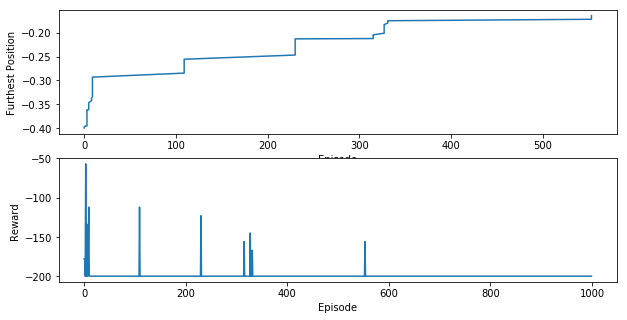

successful episodes: 0


In [3]:
max_position = -.4
positions = np.ndarray([0,2])
rewards = []
successful = []
for episode in range(1000):
    running_reward = 0
    env.reset()
    done = False
    for i in range(200):
        state, reward, done, _ = env.step(np.random.randint(0,3))
        # Give a reward for reaching a new maximum position
        if state[0] > max_position:
            max_position = state[0]
            positions = np.append(positions, [[episode, max_position]], axis=0)
            running_reward += 10
        else:
            running_reward += reward
        if done: 
            if state[0] >= 0.5:
                successful.append(episode)
            rewards.append(running_reward)
            break

print('Furthest Position: {}'.format(max_position))
plt.figure(1, figsize=[10,5])
plt.subplot(211)
plt.plot(positions[:,0], positions[:,1])
plt.xlabel('Episode')
plt.ylabel('Furthest Position')
plt.subplot(212)
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()
print('successful episodes: {}'.format(np.count_nonzero(successful)))

## Policy
We'll use a small neural network with 100 hidden units to learn our policy.

In [5]:
# I tried different weight initializations but found they did not perform well.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight, 0, 1)

class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.state_space = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        self.hidden = 100
        self.l1 = nn.Linear(self.state_space, self.hidden, bias=False)
        self.l2 = nn.Linear(self.hidden, self.action_space, bias=False)
    
    def forward(self, x):    
        model = torch.nn.Sequential(
            self.l1,
            self.l2,
        )
        return model(x)
    


We will use the Q-Learning update equation to update our action value function based on the reward for the agent's action and the maximum future action value function one step in the future.  The portion inside the brackets becomes the loss function for our neural network where $Q(s_t,a_t)$ is the output of our network and $ r_t + \gamma \max\limits_{a} Q(s_{t+1},a_{t+1}) $ is the target Q value as well as the label for our neural net turning the problem into a supervised learning problem.

$$Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \big[r_t + \gamma \max\limits_{a} Q(s_{t+1},a_{t+1}) - Q(s_t,a_t)\big]  \tag{Q-Learning}$$

In [13]:
import time

# Parameters
steps = 2000
state = env.reset()
epsilon = 0.3
gamma = 0.99
loss_history = []
reward_history = []
episodes = 3000
max_position = -0.4
learning_rate = 0.001
successes = 0
position = []

ave_reward_list = []
reward_list = []

success_list = []
time_list = []

# Initialize Policy
policy = Policy()
loss_fn = nn.MSELoss()
optimizer = optim.SGD(policy.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

start_time = time.time()

for episode in trange(episodes):
    episode_loss = 0
    episode_reward = 0
    state = env.reset()

    for s in range(steps):
        # Uncomment to render environment
        
#         if episode % 5 == 0 and episode > episodes-100:
#            env.render()
        
        # Get first action value function
        Q = policy(Variable(torch.from_numpy(state).type(torch.FloatTensor)))
        
        # Choose epsilon-greedy action
        if np.random.rand(1) < epsilon:
            action = np.random.randint(0,3)
        else:
            _, action = torch.max(Q, -1)
            action = action.item()
        
        # Step forward and receive next state and reward
        state_1, reward, done, _ = env.step(action)
        
        # Adjust reward based on car position
        reward = state_1[0] + 0.5

        # Adjust reward for task completion
        if state_1[0] >= 0.5:
            reward += 1     
        
        # Find max Q for t+1 state
        Q1 = policy(Variable(torch.from_numpy(state_1).type(torch.FloatTensor)))
        maxQ1, _ = torch.max(Q1, -1)
        
        # Create target Q value for training the policy
        Q_target = Q.clone()
        Q_target = Variable(Q_target.data)
        Q_target[action] = reward + torch.mul(maxQ1.detach(), gamma)
        
        # Calculate loss
        loss = loss_fn(Q, Q_target)
        
        # Update policy
        policy.zero_grad()
        loss.backward()
        optimizer.step()

        # Record history
        episode_loss += loss.item()
        episode_reward += reward
        # Keep track of max position
        if state_1[0] > max_position:
            max_position = state_1[0]
#             writer.add_scalar('data/max_position', max_position, episode)
        
        if done:
            if state_1[0] >= 0.5:
                # On successful epsisodes, adjust the following parameters

                # Adjust epsilon
                epsilon *= .99
#                 writer.add_scalar('data/epsilon', epsilon, episode)

                # Adjust learning rate
                scheduler.step()
#                 writer.add_scalar('data/learning_rate', optimizer.param_groups[0]['lr'], episode)

                # Record successful episode
                successes += 1
#                 writer.add_scalar('data/cumulative_success', successes, episode)
#                 writer.add_scalar('data/success', 1, episode)
            
#             elif state_1[0] < 0.5:
#                 writer.add_scalar('data/success', 0, episode)
            
            # Record history
            loss_history.append(episode_loss)
            reward_history.append(episode_reward)            
#             writer.add_scalar('data/episode_loss', episode_loss, episode)
#             writer.add_scalar('data/episode_reward', episode_reward, episode)
#             weights = np.sum(np.abs(policy.l2.weight.data.numpy()))+np.sum(np.abs(policy.l1.weight.data.numpy()))
#             writer.add_scalar('data/weights', weights, episode)
#             writer.add_scalar('data/position', state_1[0], episode)
            position.append(state_1[0])

            break
        else:
            state = state_1
    
    if (episode+1) % 100 == 0:
        ave_reward = np.mean(reward_history)
        ave_reward_list.append(ave_reward)
        reward_history = []
#     if (episode+1) % 100 == 0:    
#         print('Episode {} Average Reward: {}'.format(episode+1, ave_reward))
    exeTime = time.time() - start_time
    success_list.append(successes/episodes)
    time_list.append(exeTime)
# writer.close()
print('successful episodes: {:d} - {:.4f}%'.format(successes, successes/episodes*100))
print (time.time() - start_time, "seconds")







  0%|                                                                                         | 0/3000 [00:00<?, ?it/s]




  0%|                                                                                 | 1/3000 [00:00<07:13,  6.91it/s]




  0%|                                                                                 | 2/3000 [00:00<07:01,  7.11it/s]




  0%|                                                                                 | 3/3000 [00:00<06:56,  7.20it/s]




  0%|                                                                                 | 4/3000 [00:00<06:46,  7.38it/s]




  0%|▏                                                                                | 5/3000 [00:00<06:40,  7.48it/s]




  0%|▏                                                                                | 6/3000 [00:00<07:05,  7.04it/s]




  0%|▏                                                                                | 7/3000 [00:00<07:01,  7.10it/s]




  0

  2%|█▌                                                                              | 58/3000 [00:08<06:45,  7.25it/s]




  2%|█▌                                                                              | 59/3000 [00:08<06:36,  7.42it/s]




  2%|█▌                                                                              | 60/3000 [00:08<06:36,  7.42it/s]




  2%|█▋                                                                              | 61/3000 [00:08<06:34,  7.46it/s]




  2%|█▋                                                                              | 62/3000 [00:08<06:33,  7.46it/s]




  2%|█▋                                                                              | 63/3000 [00:08<06:34,  7.44it/s]




  2%|█▋                                                                              | 64/3000 [00:08<06:27,  7.57it/s]




  2%|█▋                                                                              | 65/3000 [00:08<06:23,  7.65it/s]




  2%|█▊ 

  4%|███                                                                            | 116/3000 [00:15<06:45,  7.12it/s]




  4%|███                                                                            | 117/3000 [00:16<06:35,  7.29it/s]




  4%|███                                                                            | 118/3000 [00:16<06:26,  7.46it/s]




  4%|███▏                                                                           | 119/3000 [00:16<06:27,  7.43it/s]




  4%|███▏                                                                           | 120/3000 [00:16<06:21,  7.55it/s]




  4%|███▏                                                                           | 121/3000 [00:16<06:13,  7.70it/s]




  4%|███▏                                                                           | 122/3000 [00:16<06:11,  7.74it/s]




  4%|███▏                                                                           | 123/3000 [00:16<06:12,  7.73it/s]




  4%|███

  6%|████▌                                                                          | 174/3000 [00:23<06:10,  7.64it/s]




  6%|████▌                                                                          | 175/3000 [00:23<06:24,  7.36it/s]




  6%|████▋                                                                          | 176/3000 [00:24<06:29,  7.25it/s]




  6%|████▋                                                                          | 177/3000 [00:24<06:21,  7.40it/s]




  6%|████▋                                                                          | 178/3000 [00:24<06:24,  7.34it/s]




  6%|████▋                                                                          | 179/3000 [00:24<06:18,  7.45it/s]




  6%|████▋                                                                          | 180/3000 [00:24<06:50,  6.88it/s]




  6%|████▊                                                                          | 181/3000 [00:24<06:37,  7.09it/s]




  6%|███

  8%|██████                                                                         | 232/3000 [00:31<06:42,  6.88it/s]




  8%|██████▏                                                                        | 233/3000 [00:32<06:34,  7.02it/s]




  8%|██████▏                                                                        | 234/3000 [00:32<06:29,  7.11it/s]




  8%|██████▏                                                                        | 235/3000 [00:32<06:14,  7.39it/s]




  8%|██████▏                                                                        | 236/3000 [00:32<06:12,  7.42it/s]




  8%|██████▏                                                                        | 237/3000 [00:32<06:51,  6.71it/s]




  8%|██████▎                                                                        | 238/3000 [00:32<06:58,  6.61it/s]




  8%|██████▎                                                                        | 239/3000 [00:32<06:33,  7.02it/s]




  8%|███

 10%|███████▋                                                                       | 290/3000 [00:39<05:24,  8.35it/s]




 10%|███████▋                                                                       | 291/3000 [00:39<05:34,  8.11it/s]




 10%|███████▋                                                                       | 292/3000 [00:39<05:44,  7.87it/s]




 10%|███████▋                                                                       | 293/3000 [00:39<05:29,  8.21it/s]




 10%|███████▋                                                                       | 294/3000 [00:40<06:01,  7.49it/s]




 10%|███████▊                                                                       | 295/3000 [00:40<06:17,  7.17it/s]




 10%|███████▊                                                                       | 296/3000 [00:40<06:30,  6.93it/s]




 10%|███████▊                                                                       | 297/3000 [00:40<06:17,  7.16it/s]




 10%|███

 12%|█████████▏                                                                     | 349/3000 [00:47<04:58,  8.90it/s]




 12%|█████████▏                                                                     | 350/3000 [00:47<04:52,  9.06it/s]




 12%|█████████▏                                                                     | 351/3000 [00:47<04:51,  9.07it/s]




 12%|█████████▎                                                                     | 352/3000 [00:47<05:05,  8.66it/s]




 12%|█████████▎                                                                     | 353/3000 [00:47<05:01,  8.79it/s]




 12%|█████████▎                                                                     | 354/3000 [00:47<05:13,  8.44it/s]




 12%|█████████▎                                                                     | 355/3000 [00:47<05:03,  8.72it/s]




 12%|█████████▎                                                                     | 356/3000 [00:47<04:58,  8.86it/s]




 12%|███

 14%|██████████▉                                                                    | 413/3000 [00:54<04:26,  9.70it/s]




 14%|██████████▉                                                                    | 414/3000 [00:54<04:33,  9.46it/s]




 14%|██████████▉                                                                    | 415/3000 [00:54<04:44,  9.10it/s]




 14%|██████████▉                                                                    | 416/3000 [00:54<04:46,  9.01it/s]




 14%|███████████                                                                    | 418/3000 [00:54<04:29,  9.58it/s]




 14%|███████████                                                                    | 419/3000 [00:54<04:32,  9.46it/s]




 14%|███████████                                                                    | 420/3000 [00:54<04:38,  9.25it/s]




 14%|███████████                                                                    | 421/3000 [00:54<04:43,  9.09it/s]




 14%|███

 16%|████████████▊                                                                  | 486/3000 [01:01<04:42,  8.91it/s]




 16%|████████████▊                                                                  | 488/3000 [01:02<04:25,  9.46it/s]




 16%|████████████▉                                                                  | 490/3000 [01:02<04:35,  9.11it/s]




 16%|████████████▉                                                                  | 491/3000 [01:02<04:36,  9.06it/s]




 16%|████████████▉                                                                  | 492/3000 [01:02<04:37,  9.03it/s]




 16%|█████████████                                                                  | 494/3000 [01:02<04:19,  9.66it/s]




 17%|█████████████                                                                  | 496/3000 [01:02<04:14,  9.82it/s]




 17%|█████████████                                                                  | 497/3000 [01:02<04:20,  9.60it/s]




 17%|███

 20%|███████████████▋                                                               | 594/3000 [01:11<03:43, 10.76it/s]




 20%|███████████████▋                                                               | 596/3000 [01:12<03:45, 10.67it/s]




 20%|███████████████▋                                                               | 598/3000 [01:12<03:35, 11.17it/s]




 20%|███████████████▊                                                               | 600/3000 [01:12<03:34, 11.18it/s]




 20%|███████████████▊                                                               | 602/3000 [01:12<03:36, 11.09it/s]




 20%|███████████████▉                                                               | 604/3000 [01:12<03:36, 11.07it/s]




 20%|███████████████▉                                                               | 606/3000 [01:13<03:51, 10.32it/s]




 20%|████████████████                                                               | 608/3000 [01:13<03:30, 11.38it/s]




 20%|███

 23%|██████████████████▎                                                            | 697/3000 [01:22<03:56,  9.74it/s]




 23%|██████████████████▍                                                            | 698/3000 [01:22<03:59,  9.60it/s]




 23%|██████████████████▍                                                            | 699/3000 [01:22<04:02,  9.50it/s]




 23%|██████████████████▍                                                            | 700/3000 [01:22<04:05,  9.35it/s]




 23%|██████████████████▍                                                            | 701/3000 [01:22<04:04,  9.41it/s]




 23%|██████████████████▌                                                            | 703/3000 [01:22<03:49, 10.03it/s]




 24%|██████████████████▌                                                            | 705/3000 [01:22<03:56,  9.71it/s]




 24%|██████████████████▌                                                            | 706/3000 [01:22<03:59,  9.57it/s]




 24%|███

 26%|████████████████████▉                                                          | 794/3000 [01:31<03:35, 10.26it/s]




 27%|████████████████████▉                                                          | 796/3000 [01:31<03:34, 10.27it/s]




 27%|█████████████████████                                                          | 798/3000 [01:31<03:26, 10.68it/s]




 27%|█████████████████████                                                          | 800/3000 [01:32<03:34, 10.24it/s]




 27%|█████████████████████                                                          | 802/3000 [01:32<03:34, 10.23it/s]




 27%|█████████████████████▏                                                         | 804/3000 [01:32<03:29, 10.49it/s]




 27%|█████████████████████▏                                                         | 806/3000 [01:32<03:29, 10.46it/s]




 27%|█████████████████████▎                                                         | 808/3000 [01:32<03:25, 10.68it/s]




 27%|███

 30%|███████████████████████▋                                                       | 898/3000 [01:41<03:25, 10.22it/s]




 30%|███████████████████████▋                                                       | 900/3000 [01:41<03:32,  9.89it/s]




 30%|███████████████████████▊                                                       | 902/3000 [01:42<03:34,  9.78it/s]




 30%|███████████████████████▊                                                       | 904/3000 [01:42<03:34,  9.77it/s]




 30%|███████████████████████▊                                                       | 905/3000 [01:42<03:49,  9.12it/s]




 30%|███████████████████████▊                                                       | 906/3000 [01:42<03:45,  9.30it/s]




 30%|███████████████████████▉                                                       | 907/3000 [01:42<03:56,  8.85it/s]




 30%|███████████████████████▉                                                       | 908/3000 [01:42<04:11,  8.31it/s]




 30%|███

 33%|██████████████████████████                                                    | 1000/3000 [01:51<02:48, 11.87it/s]




 33%|██████████████████████████                                                    | 1002/3000 [01:51<03:02, 10.96it/s]




 33%|██████████████████████████                                                    | 1004/3000 [01:51<02:45, 12.04it/s]




 34%|██████████████████████████▏                                                   | 1006/3000 [01:51<02:45, 12.05it/s]




 34%|██████████████████████████▏                                                   | 1008/3000 [01:51<02:52, 11.56it/s]




 34%|██████████████████████████▎                                                   | 1010/3000 [01:52<03:07, 10.60it/s]




 34%|██████████████████████████▎                                                   | 1012/3000 [01:52<02:59, 11.08it/s]




 34%|██████████████████████████▎                                                   | 1014/3000 [01:52<03:03, 10.84it/s]




 34%|███

 37%|████████████████████████████▊                                                 | 1109/3000 [02:01<02:40, 11.81it/s]




 37%|████████████████████████████▉                                                 | 1111/3000 [02:01<02:43, 11.58it/s]




 37%|████████████████████████████▉                                                 | 1113/3000 [02:01<02:47, 11.29it/s]




 37%|████████████████████████████▉                                                 | 1115/3000 [02:01<02:39, 11.82it/s]




 37%|█████████████████████████████                                                 | 1117/3000 [02:02<02:50, 11.07it/s]




 37%|█████████████████████████████                                                 | 1119/3000 [02:02<02:48, 11.17it/s]




 37%|█████████████████████████████▏                                                | 1121/3000 [02:02<02:39, 11.75it/s]




 37%|█████████████████████████████▏                                                | 1123/3000 [02:02<02:50, 11.01it/s]




 38%|███

 41%|███████████████████████████████▊                                              | 1225/3000 [02:11<02:20, 12.64it/s]




 41%|███████████████████████████████▉                                              | 1227/3000 [02:11<02:24, 12.28it/s]




 41%|███████████████████████████████▉                                              | 1229/3000 [02:11<02:14, 13.13it/s]




 41%|████████████████████████████████                                              | 1231/3000 [02:12<02:30, 11.78it/s]




 41%|████████████████████████████████                                              | 1233/3000 [02:12<02:32, 11.60it/s]




 41%|████████████████████████████████                                              | 1235/3000 [02:12<02:36, 11.27it/s]




 41%|████████████████████████████████▏                                             | 1237/3000 [02:12<02:30, 11.70it/s]




 41%|████████████████████████████████▏                                             | 1239/3000 [02:12<02:24, 12.18it/s]




 41%|███

 44%|██████████████████████████████████▌                                           | 1328/3000 [02:21<03:08,  8.87it/s]




 44%|██████████████████████████████████▌                                           | 1329/3000 [02:21<03:07,  8.92it/s]




 44%|██████████████████████████████████▌                                           | 1331/3000 [02:21<02:42, 10.30it/s]




 44%|██████████████████████████████████▋                                           | 1333/3000 [02:21<02:42, 10.27it/s]




 44%|██████████████████████████████████▋                                           | 1335/3000 [02:21<02:38, 10.50it/s]




 45%|██████████████████████████████████▊                                           | 1337/3000 [02:22<02:25, 11.43it/s]




 45%|██████████████████████████████████▊                                           | 1339/3000 [02:22<02:17, 12.06it/s]




 45%|██████████████████████████████████▊                                           | 1341/3000 [02:22<02:30, 11.05it/s]




 45%|███

 47%|█████████████████████████████████████                                         | 1424/3000 [02:30<02:30, 10.47it/s]




 48%|█████████████████████████████████████                                         | 1426/3000 [02:30<02:15, 11.61it/s]




 48%|█████████████████████████████████████▏                                        | 1428/3000 [02:30<02:15, 11.56it/s]




 48%|█████████████████████████████████████▏                                        | 1430/3000 [02:31<02:15, 11.61it/s]




 48%|█████████████████████████████████████▏                                        | 1432/3000 [02:31<02:05, 12.47it/s]




 48%|█████████████████████████████████████▎                                        | 1434/3000 [02:31<02:09, 12.08it/s]




 48%|█████████████████████████████████████▎                                        | 1436/3000 [02:31<02:12, 11.85it/s]




 48%|█████████████████████████████████████▍                                        | 1438/3000 [02:31<02:19, 11.16it/s]




 48%|███

 51%|███████████████████████████████████████▉                                      | 1538/3000 [02:41<02:27,  9.91it/s]




 51%|████████████████████████████████████████                                      | 1540/3000 [02:41<02:28,  9.83it/s]




 51%|████████████████████████████████████████                                      | 1542/3000 [02:41<02:19, 10.47it/s]




 51%|████████████████████████████████████████▏                                     | 1544/3000 [02:41<02:08, 11.35it/s]




 52%|████████████████████████████████████████▏                                     | 1546/3000 [02:41<02:18, 10.49it/s]




 52%|████████████████████████████████████████▏                                     | 1548/3000 [02:42<02:35,  9.35it/s]




 52%|████████████████████████████████████████▎                                     | 1549/3000 [02:42<02:42,  8.91it/s]




 52%|████████████████████████████████████████▎                                     | 1550/3000 [02:42<03:05,  7.80it/s]




 52%|███

 55%|██████████████████████████████████████████▌                                   | 1639/3000 [02:51<02:25,  9.38it/s]




 55%|██████████████████████████████████████████▋                                   | 1640/3000 [02:51<02:34,  8.82it/s]




 55%|██████████████████████████████████████████▋                                   | 1642/3000 [02:51<02:24,  9.42it/s]




 55%|██████████████████████████████████████████▋                                   | 1644/3000 [02:52<02:10, 10.38it/s]




 55%|██████████████████████████████████████████▊                                   | 1646/3000 [02:52<02:08, 10.52it/s]




 55%|██████████████████████████████████████████▊                                   | 1648/3000 [02:52<02:21,  9.55it/s]




 55%|██████████████████████████████████████████▊                                   | 1649/3000 [02:52<02:19,  9.68it/s]




 55%|██████████████████████████████████████████▉                                   | 1651/3000 [02:52<02:12, 10.16it/s]




 55%|███

 58%|█████████████████████████████████████████████▏                                | 1739/3000 [03:01<02:02, 10.29it/s]




 58%|█████████████████████████████████████████████▎                                | 1741/3000 [03:01<02:08,  9.80it/s]




 58%|█████████████████████████████████████████████▎                                | 1742/3000 [03:02<02:13,  9.40it/s]




 58%|█████████████████████████████████████████████▎                                | 1743/3000 [03:02<02:18,  9.06it/s]




 58%|█████████████████████████████████████████████▎                                | 1744/3000 [03:02<02:18,  9.08it/s]




 58%|█████████████████████████████████████████████▎                                | 1745/3000 [03:02<02:20,  8.92it/s]




 58%|█████████████████████████████████████████████▍                                | 1746/3000 [03:02<02:23,  8.76it/s]




 58%|█████████████████████████████████████████████▍                                | 1748/3000 [03:02<02:15,  9.23it/s]




 58%|███

 62%|████████████████████████████████████████████████                              | 1848/3000 [03:12<01:40, 11.50it/s]




 62%|████████████████████████████████████████████████                              | 1850/3000 [03:12<01:39, 11.57it/s]




 62%|████████████████████████████████████████████████▏                             | 1852/3000 [03:12<01:32, 12.37it/s]




 62%|████████████████████████████████████████████████▏                             | 1854/3000 [03:12<01:43, 11.10it/s]




 62%|████████████████████████████████████████████████▎                             | 1856/3000 [03:12<01:39, 11.45it/s]




 62%|████████████████████████████████████████████████▎                             | 1858/3000 [03:12<01:46, 10.75it/s]




 62%|████████████████████████████████████████████████▎                             | 1860/3000 [03:13<01:50, 10.36it/s]




 62%|████████████████████████████████████████████████▍                             | 1862/3000 [03:13<01:55,  9.84it/s]




 62%|███

 65%|██████████████████████████████████████████████████▍                           | 1938/3000 [03:21<02:19,  7.63it/s]




 65%|██████████████████████████████████████████████████▍                           | 1939/3000 [03:22<02:26,  7.25it/s]




 65%|██████████████████████████████████████████████████▍                           | 1940/3000 [03:22<02:31,  7.00it/s]




 65%|██████████████████████████████████████████████████▍                           | 1941/3000 [03:22<02:33,  6.88it/s]




 65%|██████████████████████████████████████████████████▍                           | 1942/3000 [03:22<02:34,  6.84it/s]




 65%|██████████████████████████████████████████████████▌                           | 1943/3000 [03:22<02:27,  7.15it/s]




 65%|██████████████████████████████████████████████████▌                           | 1945/3000 [03:22<02:15,  7.80it/s]




 65%|██████████████████████████████████████████████████▌                           | 1947/3000 [03:23<02:10,  8.09it/s]




 65%|███

 67%|████████████████████████████████████████████████████▌                         | 2020/3000 [03:31<01:49,  8.95it/s]




 67%|████████████████████████████████████████████████████▌                         | 2021/3000 [03:31<01:58,  8.26it/s]




 67%|████████████████████████████████████████████████████▌                         | 2023/3000 [03:31<01:53,  8.60it/s]




 67%|████████████████████████████████████████████████████▌                         | 2024/3000 [03:31<01:51,  8.79it/s]




 68%|████████████████████████████████████████████████████▋                         | 2025/3000 [03:31<01:56,  8.37it/s]




 68%|████████████████████████████████████████████████████▋                         | 2027/3000 [03:31<01:42,  9.52it/s]




 68%|████████████████████████████████████████████████████▊                         | 2029/3000 [03:32<01:48,  8.96it/s]




 68%|████████████████████████████████████████████████████▊                         | 2031/3000 [03:32<01:45,  9.19it/s]




 68%|███

 70%|██████████████████████████████████████████████████████▌                       | 2098/3000 [03:40<01:50,  8.20it/s]




 70%|██████████████████████████████████████████████████████▌                       | 2099/3000 [03:40<01:49,  8.23it/s]




 70%|██████████████████████████████████████████████████████▌                       | 2100/3000 [03:40<01:51,  8.09it/s]




 70%|██████████████████████████████████████████████████████▋                       | 2101/3000 [03:40<01:50,  8.11it/s]




 70%|██████████████████████████████████████████████████████▋                       | 2102/3000 [03:40<01:45,  8.55it/s]




 70%|██████████████████████████████████████████████████████▋                       | 2103/3000 [03:40<01:44,  8.58it/s]




 70%|██████████████████████████████████████████████████████▋                       | 2104/3000 [03:40<01:46,  8.43it/s]




 70%|██████████████████████████████████████████████████████▋                       | 2105/3000 [03:40<01:48,  8.23it/s]




 70%|███

 72%|████████████████████████████████████████████████████████▍                     | 2171/3000 [03:48<01:52,  7.40it/s]




 72%|████████████████████████████████████████████████████████▍                     | 2172/3000 [03:48<01:51,  7.44it/s]




 72%|████████████████████████████████████████████████████████▍                     | 2173/3000 [03:48<01:53,  7.26it/s]




 72%|████████████████████████████████████████████████████████▌                     | 2175/3000 [03:49<01:46,  7.72it/s]




 73%|████████████████████████████████████████████████████████▌                     | 2176/3000 [03:49<01:45,  7.78it/s]




 73%|████████████████████████████████████████████████████████▋                     | 2178/3000 [03:49<01:41,  8.13it/s]




 73%|████████████████████████████████████████████████████████▋                     | 2180/3000 [03:49<01:34,  8.71it/s]




 73%|████████████████████████████████████████████████████████▋                     | 2182/3000 [03:49<01:33,  8.79it/s]




 73%|███

 75%|██████████████████████████████████████████████████████████▌                   | 2251/3000 [03:57<01:27,  8.56it/s]




 75%|██████████████████████████████████████████████████████████▌                   | 2252/3000 [03:57<01:28,  8.45it/s]




 75%|██████████████████████████████████████████████████████████▌                   | 2254/3000 [03:58<01:23,  8.94it/s]




 75%|██████████████████████████████████████████████████████████▋                   | 2255/3000 [03:58<01:26,  8.59it/s]




 75%|██████████████████████████████████████████████████████████▋                   | 2256/3000 [03:58<01:27,  8.49it/s]




 75%|██████████████████████████████████████████████████████████▋                   | 2258/3000 [03:58<01:21,  9.07it/s]




 75%|██████████████████████████████████████████████████████████▋                   | 2259/3000 [03:58<01:24,  8.81it/s]




 75%|██████████████████████████████████████████████████████████▊                   | 2260/3000 [03:58<01:25,  8.68it/s]




 75%|███

 78%|████████████████████████████████████████████████████████████▊                 | 2341/3000 [04:07<01:16,  8.62it/s]




 78%|████████████████████████████████████████████████████████████▉                 | 2343/3000 [04:07<01:13,  8.95it/s]




 78%|████████████████████████████████████████████████████████████▉                 | 2344/3000 [04:07<01:19,  8.29it/s]




 78%|████████████████████████████████████████████████████████████▉                 | 2345/3000 [04:07<01:20,  8.13it/s]




 78%|█████████████████████████████████████████████████████████████                 | 2347/3000 [04:07<01:15,  8.68it/s]




 78%|█████████████████████████████████████████████████████████████                 | 2348/3000 [04:07<01:18,  8.35it/s]




 78%|█████████████████████████████████████████████████████████████                 | 2350/3000 [04:08<01:13,  8.85it/s]




 78%|█████████████████████████████████████████████████████████████▏                | 2351/3000 [04:08<01:14,  8.73it/s]




 78%|███

 81%|██████████████████████████████████████████████████████████████▉               | 2420/3000 [04:15<00:54, 10.66it/s]




 81%|██████████████████████████████████████████████████████████████▉               | 2422/3000 [04:15<00:55, 10.50it/s]




 81%|███████████████████████████████████████████████████████████████               | 2424/3000 [04:16<00:59,  9.62it/s]




 81%|███████████████████████████████████████████████████████████████               | 2425/3000 [04:16<01:03,  9.04it/s]




 81%|███████████████████████████████████████████████████████████████               | 2427/3000 [04:16<00:56, 10.19it/s]




 81%|███████████████████████████████████████████████████████████████▏              | 2429/3000 [04:16<00:51, 11.13it/s]




 81%|███████████████████████████████████████████████████████████████▏              | 2431/3000 [04:16<00:51, 11.11it/s]




 81%|███████████████████████████████████████████████████████████████▎              | 2433/3000 [04:16<00:48, 11.63it/s]




 81%|███

 84%|█████████████████████████████████████████████████████████████████▎            | 2510/3000 [04:24<00:57,  8.51it/s]




 84%|█████████████████████████████████████████████████████████████████▎            | 2511/3000 [04:25<00:58,  8.38it/s]




 84%|█████████████████████████████████████████████████████████████████▎            | 2512/3000 [04:25<00:58,  8.34it/s]




 84%|█████████████████████████████████████████████████████████████████▎            | 2514/3000 [04:25<00:54,  8.99it/s]




 84%|█████████████████████████████████████████████████████████████████▍            | 2516/3000 [04:25<00:47, 10.15it/s]




 84%|█████████████████████████████████████████████████████████████████▍            | 2518/3000 [04:25<00:46, 10.45it/s]




 84%|█████████████████████████████████████████████████████████████████▌            | 2520/3000 [04:25<00:48,  9.89it/s]




 84%|█████████████████████████████████████████████████████████████████▌            | 2522/3000 [04:26<00:49,  9.58it/s]




 84%|███

 86%|███████████████████████████████████████████████████████████████████▏          | 2585/3000 [04:33<00:51,  8.06it/s]




 86%|███████████████████████████████████████████████████████████████████▎          | 2587/3000 [04:33<00:47,  8.62it/s]




 86%|███████████████████████████████████████████████████████████████████▎          | 2588/3000 [04:34<00:48,  8.45it/s]




 86%|███████████████████████████████████████████████████████████████████▎          | 2590/3000 [04:34<00:43,  9.48it/s]




 86%|███████████████████████████████████████████████████████████████████▍          | 2592/3000 [04:34<00:42,  9.69it/s]




 86%|███████████████████████████████████████████████████████████████████▍          | 2594/3000 [04:34<00:40,  9.90it/s]




 87%|███████████████████████████████████████████████████████████████████▍          | 2596/3000 [04:34<00:40,  9.99it/s]




 87%|███████████████████████████████████████████████████████████████████▌          | 2598/3000 [04:35<00:42,  9.47it/s]




 87%|███

 89%|█████████████████████████████████████████████████████████████████████▍        | 2673/3000 [04:43<00:29, 10.94it/s]




 89%|█████████████████████████████████████████████████████████████████████▌        | 2675/3000 [04:43<00:30, 10.64it/s]




 89%|█████████████████████████████████████████████████████████████████████▌        | 2677/3000 [04:43<00:32,  9.89it/s]




 89%|█████████████████████████████████████████████████████████████████████▋        | 2679/3000 [04:43<00:33,  9.65it/s]




 89%|█████████████████████████████████████████████████████████████████████▋        | 2681/3000 [04:44<00:30, 10.46it/s]




 89%|█████████████████████████████████████████████████████████████████████▊        | 2683/3000 [04:44<00:31,  9.91it/s]




 90%|█████████████████████████████████████████████████████████████████████▊        | 2685/3000 [04:44<00:33,  9.28it/s]




 90%|█████████████████████████████████████████████████████████████████████▊        | 2686/3000 [04:44<00:35,  8.91it/s]




 90%|███

 92%|███████████████████████████████████████████████████████████████████████▋      | 2756/3000 [04:52<00:26,  9.22it/s]




 92%|███████████████████████████████████████████████████████████████████████▋      | 2757/3000 [04:52<00:28,  8.50it/s]




 92%|███████████████████████████████████████████████████████████████████████▋      | 2759/3000 [04:52<00:25,  9.47it/s]




 92%|███████████████████████████████████████████████████████████████████████▊      | 2761/3000 [04:52<00:23,  9.96it/s]




 92%|███████████████████████████████████████████████████████████████████████▊      | 2763/3000 [04:52<00:23, 10.12it/s]




 92%|███████████████████████████████████████████████████████████████████████▉      | 2765/3000 [04:53<00:23,  9.97it/s]




 92%|███████████████████████████████████████████████████████████████████████▉      | 2767/3000 [04:53<00:23, 10.07it/s]




 92%|███████████████████████████████████████████████████████████████████████▉      | 2769/3000 [04:53<00:25,  9.15it/s]




 92%|███

 94%|█████████████████████████████████████████████████████████████████████████▋    | 2833/3000 [05:00<00:17,  9.42it/s]




 94%|█████████████████████████████████████████████████████████████████████████▋    | 2834/3000 [05:00<00:19,  8.72it/s]




 95%|█████████████████████████████████████████████████████████████████████████▋    | 2836/3000 [05:01<00:17,  9.36it/s]




 95%|█████████████████████████████████████████████████████████████████████████▊    | 2838/3000 [05:01<00:16,  9.72it/s]




 95%|█████████████████████████████████████████████████████████████████████████▊    | 2840/3000 [05:01<00:15, 10.04it/s]




 95%|█████████████████████████████████████████████████████████████████████████▉    | 2842/3000 [05:01<00:16,  9.53it/s]




 95%|█████████████████████████████████████████████████████████████████████████▉    | 2843/3000 [05:01<00:18,  8.56it/s]




 95%|█████████████████████████████████████████████████████████████████████████▉    | 2845/3000 [05:02<00:16,  9.16it/s]




 95%|███

 97%|███████████████████████████████████████████████████████████████████████████▊  | 2916/3000 [05:09<00:09,  8.54it/s]




 97%|███████████████████████████████████████████████████████████████████████████▊  | 2918/3000 [05:09<00:09,  9.11it/s]




 97%|███████████████████████████████████████████████████████████████████████████▉  | 2919/3000 [05:10<00:09,  8.75it/s]




 97%|███████████████████████████████████████████████████████████████████████████▉  | 2921/3000 [05:10<00:08,  9.73it/s]




 97%|███████████████████████████████████████████████████████████████████████████▉  | 2923/3000 [05:10<00:08,  9.53it/s]




 97%|████████████████████████████████████████████████████████████████████████████  | 2924/3000 [05:10<00:08,  9.17it/s]




 98%|████████████████████████████████████████████████████████████████████████████  | 2926/3000 [05:10<00:07,  9.27it/s]




 98%|████████████████████████████████████████████████████████████████████████████  | 2927/3000 [05:10<00:08,  8.85it/s]




 98%|███

successful episodes: 2692 - 89.7333%
318.4386074542999 seconds


## Plot Results
Around episode 330 the agent begins to successfully complete episodes, and around episode 370, the agent completes almost every episode successfully.

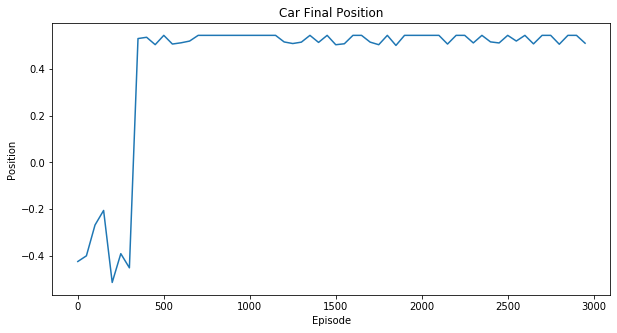

In [25]:
plt.figure(2, figsize=[10,5])
p = pd.Series(position)
ma = p.rolling(10).mean()
plt.plot(p[0:-1:50])
# plt.plot(ma)
plt.xlabel('Episode')
plt.ylabel('Position')
plt.title('Car Final Position')
plt.savefig('Final Position - Modified.png')
plt.show()

In [16]:
import matplotlib.pyplot as plt

plt.plot(100*(np.arange(len(ave_reward_list)) + 1), ave_reward_list)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')
plt.savefig('rewards_modified.jpg')      
plt.close()  

In [17]:
import matplotlib.pyplot as plt

plt.plot(time_list, success_list)
plt.xlabel('Execution time (seconds)')
plt.ylabel('Average success')
plt.title('Average success vs execution time')
plt.savefig('success_modified.jpg')      
plt.close()  

<iframe width="900" position="800" frameborder="0" scrolling="no" src="//plot.ly/~ts1829/22.embed"></iframe>

## Visualize Policy
The learned policy can be clearly visualized in the plot below.  The agent learns to move left when the car's velocity is negative and then switch directions when the car's velocity becomes positive with a few position and velocity combinations on the far left of the environment where the agent will do nothing.

In [7]:
X = np.random.uniform(-1.2, 0.6, 10000)
Y = np.random.uniform(-0.07, 0.07, 10000)
Z = []
for i in range(len(X)):
    _, temp = torch.max(policy(Variable(torch.from_numpy(np.array([X[i],Y[i]]))).type(torch.FloatTensor)), dim =-1)
    z = temp.item()
    Z.append(z)
Z = pd.Series(Z)
colors = {0:'blue',1:'lime',2:'red'}
colors = Z.apply(lambda x:colors[x])
labels = ['Left','Right','Nothing']

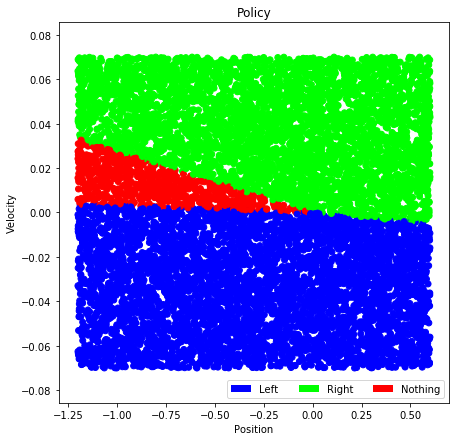

In [8]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
fig = plt.figure(5, figsize=[7,7])
ax = fig.gca()
plt.set_cmap('brg')
surf = ax.scatter(X,Y, c=Z)
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Policy')
recs = []
for i in range(0,3):
     recs.append(mpatches.Rectangle((0,0),1,1,fc=sorted(colors.unique())[i]))
plt.legend(recs,labels,loc=4,ncol=3)
fig.savefig('Policy - Modified.png')
plt.show()